<a href="https://colab.research.google.com/github/NikolayLenkovNikolaev/R_for_Pharmacometrics/blob/main/Dose_PK_ExposureSingle_Ascxending_Dose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
def trapez(df):
  x = df["TIME"].to_list()
  y = df["LIDV"].to_list()
  area = np.trapz(y, x)

  return area

def get_max(df):
  max = df["LIDV"].max()
  return max

def get_first(df, str):
  L = df[str].to_list()
  U = L[0]
  return U

## Overview

This document contains exploratory plots for single ascending dose PK data as well as the Python code that generates these graphs. The plots presened here are based on simulated data form Novartis.


## Setup

In [118]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

from packaging import version
import sklearn
print(f"Sciket Learn version:   {sklearn.__version__}")
print(f"Lifelines version:      {sklearn.__version__}")
print(f"Sciket Survive version: {sklearn.__version__}")

from google.colab import drive
drive.mount('/content/drive/')

Sciket Learn version:   1.2.2
Lifelines version:      1.2.2
Sciket Survive version: 1.2.2
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load Dataset

In [162]:
# load dataset
path = "/content/drive/MyDrive/Python_pharma/data/"

file = "Single_Ascending_Dose_Dataset2.csv"

pkpd_data = pd.read_csv(path+file)

pkpd_data.shape


# FILTER

# pkpd_data = pkpd_data[pkpd_data["ID"].isin([1,16])]
# pkpd_data.shape

(700, 15)

In [163]:
#ensure dataset has all the necessary columns
pkpd_data["LIDV_NORM"] = pkpd_data["LIDV"] / pkpd_data["DOSE"]
pkpd_data["LIDV_UNIT"] = np.where(pkpd_data["CMT"] == 2, "ng/ml", " ")


pkpd_data = pkpd_data.sort_values("DOSE")
pkpd_data["TRTACT_low2high"] = pkpd_data["TRTACT"]
pkpd_data["TRTACT_high2low"] = pkpd_data["TRTACT"]
pkpd_data = pkpd_data[['ID', 'TIME', 'NOMTIME', 'TIMEUNIT', 'AMT', 'LIDV', 'CMT', 'NAME',
                       'EVENTU', 'CENS', 'EVID', 'WEIGHTB', 'SEX', 'DOSE',
                        'LIDV_NORM', 'LIDV_UNIT', 'TRTACT_low2high', 'TRTACT_high2low']]
pkpd_data.shape

(700, 18)

In [164]:
pk_data = pkpd_data[pkpd_data["CMT"] == 2]
pk_data.groupby(["ID", "DOSE"])
pk_data.shape
NCA = pk_data[pk_data['LIDV'].notna()]
NCA.shape

(650, 18)

(600, 18)

In [168]:
#NCA= NCA[["ID", "TIME", "LIDV"]]
NCA = NCA.sort_values(["ID", "TIME"])
NCA.shape

df = pd.DataFrame()
df["AUC_last"] = NCA.groupby("ID").apply(trapez)
df.shape

(600, 18)

(50, 1)

In [172]:
df["C_max"] = NCA.groupby("ID").apply(get_max)
df.shape

(50, 2)

In [174]:
df["SEX"]     = NCA.groupby("ID").apply(get_first, "SEX")
df["WEIGHTB"] = NCA.groupby("ID").apply(get_first, "WEIGHTB")
df["DOSE"]    = NCA.groupby("ID").apply(get_first, "DOSE")
df["ID"]      = NCA.groupby("ID").apply(get_first, "ID")
df = df.reset_index(drop=True)

df = df[["ID", "DOSE", "AUC_last", "C_max", "SEX", "WEIGHTB"]]

df2 = df[["ID", "DOSE", "SEX", "WEIGHTB"]]

df1= df[["ID", "AUC_last", "C_max"]]

df.shape
df1.shape
df2.shape

(50, 6)

(50, 3)

(50, 4)

In [177]:
df4 = pd.melt(df1, id_vars=['ID'],
        value_vars=['AUC_last', 'C_max'], var_name='PARAM', value_name='VALUE',  ignore_index=False)
df4.shape

(100, 3)

In [180]:
df5 = df4.merge(df2, left_on='ID', right_on='ID')
df5.shape
df5.columns

(100, 6)

Index(['ID', 'PARAM', 'VALUE', 'DOSE', 'SEX', 'WEIGHTB'], dtype='object')

In [182]:
df5["VALUE_NORM"] = df5["VALUE"]/df5["DOSE"]
df5 = df5.sort_values("ID")
df5.shape

(100, 7)

## Provide an overview of the data

<Axes: xlabel='NOMTIME', ylabel='LIDV'>

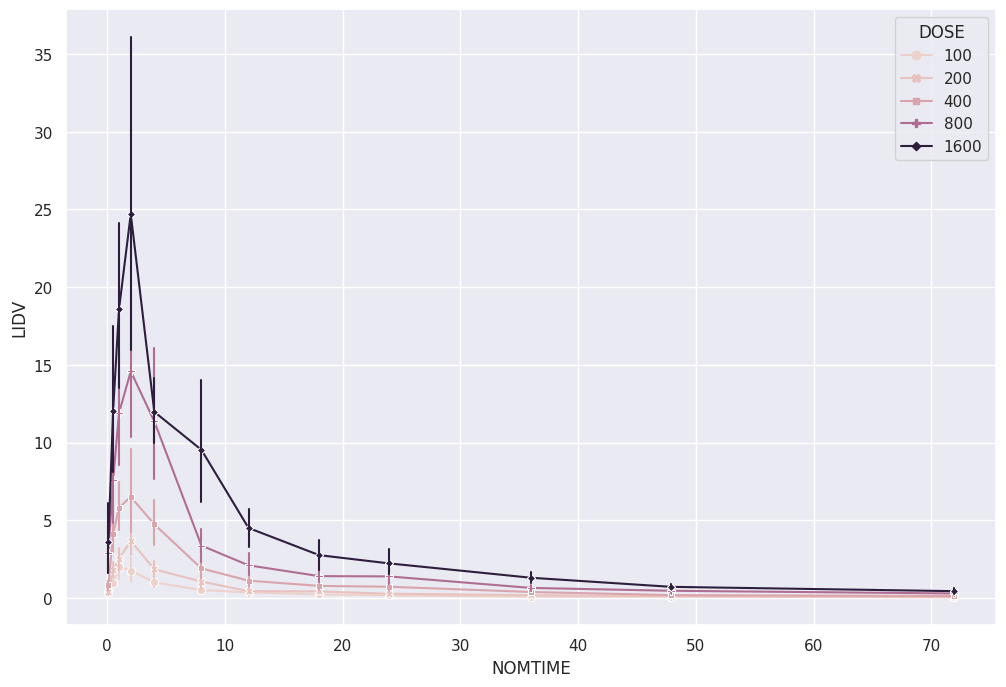

In [183]:
sns.lineplot(x="NOMTIME",
             y="LIDV",
             hue="DOSE",
             data=pk_data,
             style="DOSE",
             markers=True,
             dashes=False,
             err_style="bars",
             errorbar=("ci"))
plt.show()

<Axes: xlabel='NOMTIME', ylabel='LIDV'>

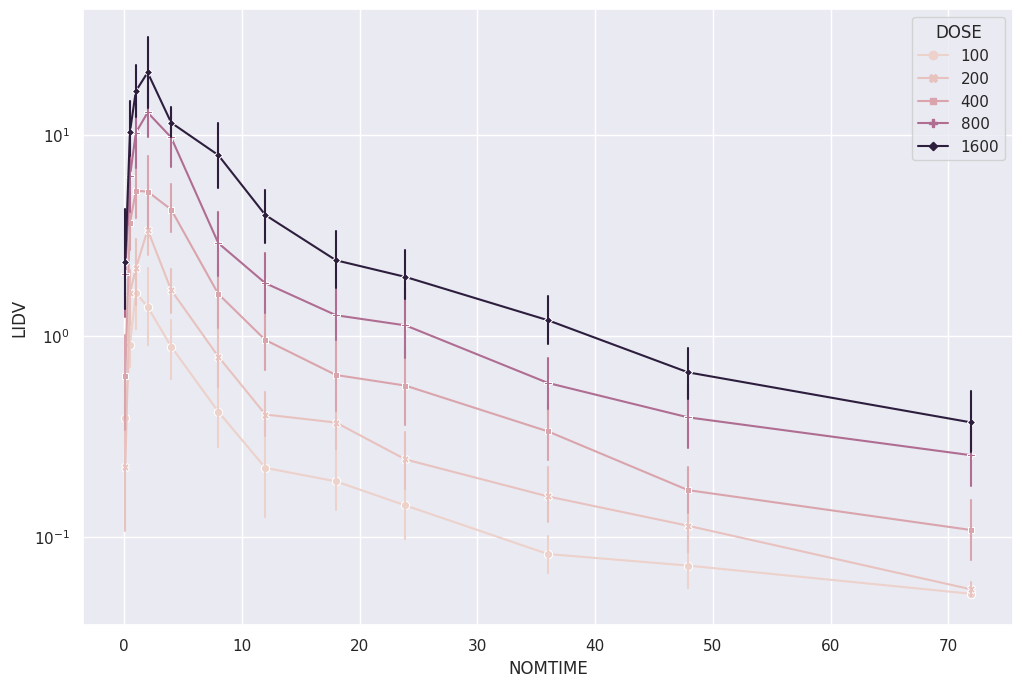

In [186]:
plt.yscale('log')
sns.lineplot(x="NOMTIME",
             y="LIDV",
             hue="DOSE",
             data=pk_data,
             style="DOSE",
             markers=True,
             dashes=False,
             err_style="bars",
             errorbar=("ci"))
plt.show()

## Concentration over time, faceted by Dose, mean +/- 95% CI, overlaid on gray spaghetti plots

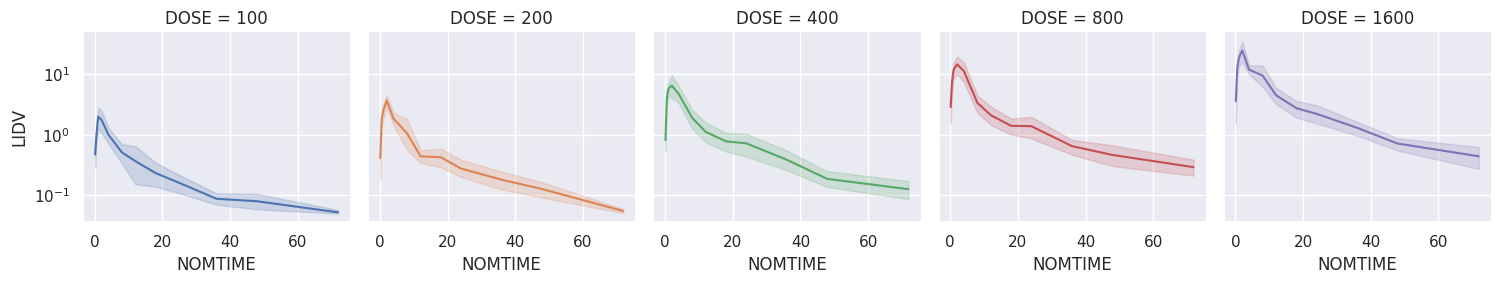

In [187]:
g = sns.FacetGrid(pk_data,
                  col="DOSE",
                  hue="DOSE",
                  col_wrap=5)
g.map(sns.lineplot, "NOMTIME","LIDV")
plt.yscale('log')
plt.show()

## Assess the dose linearity of exposure
## Dose Normalized Concentration over time, colored by Dose, mean +/- 95% CI

<Axes: xlabel='NOMTIME', ylabel='LIDV_NORM'>

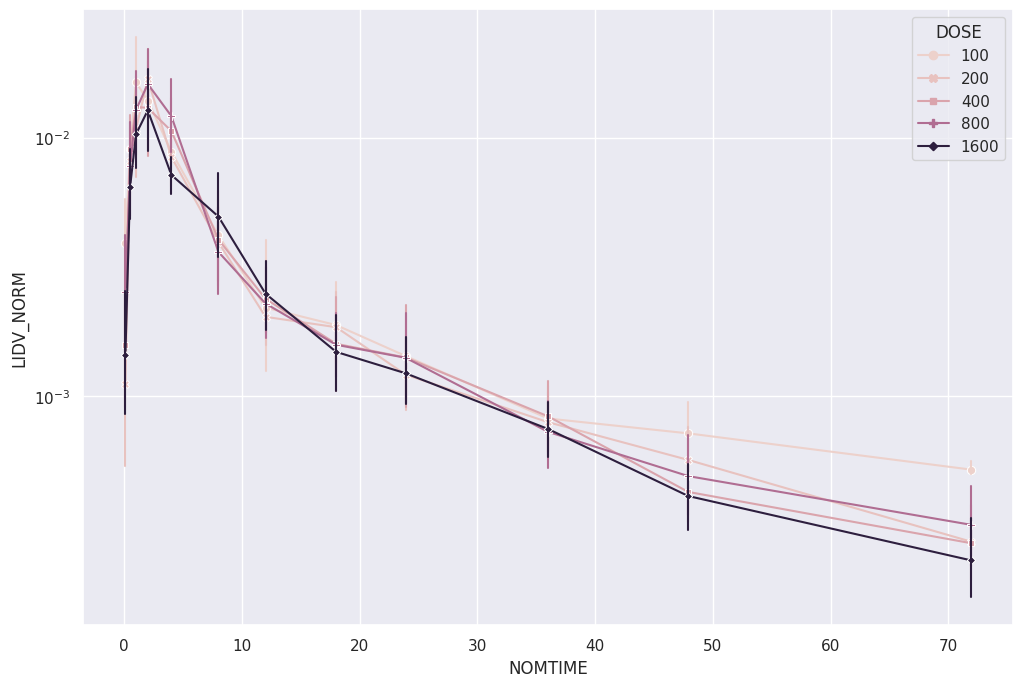

In [188]:
plt.yscale('log')
sns.lineplot(x="NOMTIME",
             y="LIDV_NORM",
             hue="DOSE",
             data=pk_data,
             style="DOSE",
             markers=True,
             dashes=False,
             err_style="bars",
             errorbar=("ci"))

## NCA of dose normalized AUC and Cmax vs Dose

Observe the dose normalized AUC and Cmax over different doses. Does the relationship appear to be constant across doses or do some doses stand out from the rest? Can you think of reasons why some would stand out? For example, the lowest dose may have dose normalized AUC much higher than the rest, could this be due to BLQ observations? If the highest doses have dose normalized AUC much higher than the others, could this be due to nonlinear clearance, with clearance saturating at higher doses? If the highest doses have dose normalized AUC much lower than the others, could there be saturation of bioavailability, reaching the maximum absorbable dose?

In [198]:
df5.shape
#df5[df5["VALUE"]== 1.350]

df5.head()

(100, 7)

,ID,PARAM,VALUE,DOSE,SEX,WEIGHTB,VALUE_NORM
0,1,AUC_last,10.984329,100,Male,77.9,0.109843
1,1,C_max,1.350000,100,Male,77.9,0.013500
2,2,AUC_last,14.164724,100,Male,74.7,0.141647
3,2,C_max,1.260000,100,Male,74.7,0.012600
4,3,AUC_last,7.655013,100,Male,99.5,0.076550


In [199]:
c_max = df5[df5["PARAM"] == "C_max"]
c_max.head()
c_max.shape

,ID,PARAM,VALUE,DOSE,SEX,WEIGHTB,VALUE_NORM
1,1,C_max,1.350,100,Male,77.9,0.01350
3,2,C_max,1.260,100,Male,74.7,0.01260
5,3,C_max,0.763,100,Male,99.5,0.00763
7,4,C_max,1.060,100,Male,106.0,0.01060
9,5,C_max,1.040,100,Male,106.0,0.01040


(50, 7)

In [200]:
auc = df5[df5["PARAM"]=="AUC_last"]
auc.head()
auc.shape

,ID,PARAM,VALUE,DOSE,SEX,WEIGHTB,VALUE_NORM
0,1,AUC_last,10.984329,100,Male,77.9,0.109843
2,2,AUC_last,14.164724,100,Male,74.7,0.141647
4,3,AUC_last,7.655013,100,Male,99.5,0.076550
6,4,AUC_last,8.668306,100,Male,106.0,0.086683
8,5,AUC_last,8.583599,100,Male,106.0,0.085836


(50, 7)

<Axes: xlabel='DOSE', ylabel='VALUE_NORM'>

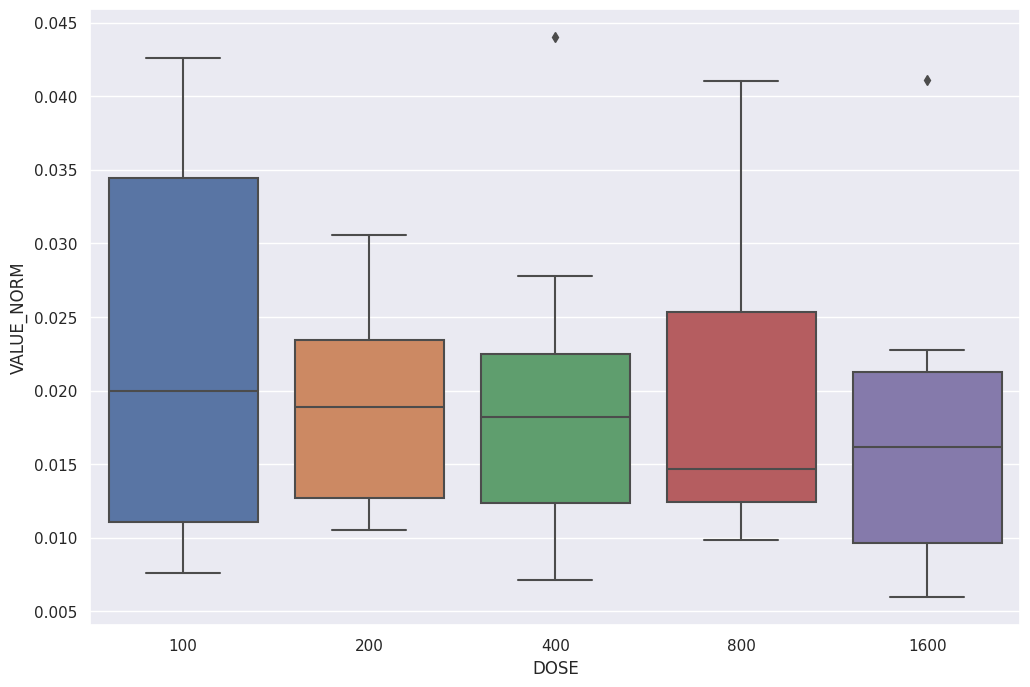

In [201]:
sns.boxplot(x="DOSE", y="VALUE_NORM", data= c_max)
#sns.regplot(x="DOSE", y="VALUE_NORM", data= c_max, scatter=False)
plt.show()

<Axes: xlabel='DOSE', ylabel='VALUE_NORM'>

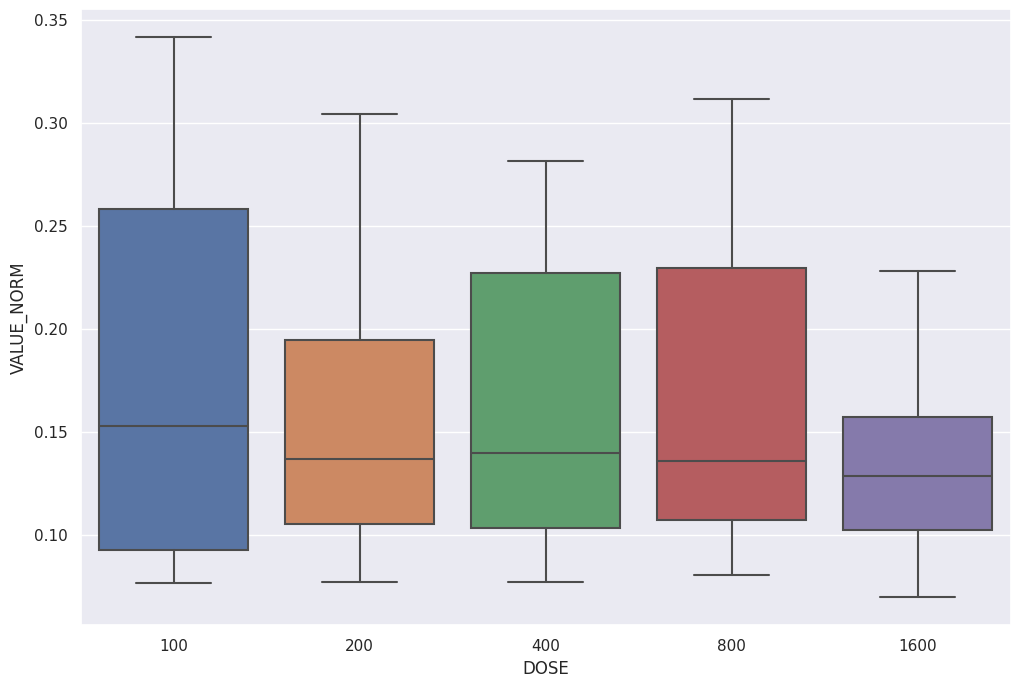

In [202]:
sns.boxplot(x="DOSE", y="VALUE_NORM", data= auc)
#sns.regplot(x="DOSE", y="VALUE_NORM", data= auc, scatter=False)
plt.show()

## Explore variability
Now that the overall trends in the mean data have been observed, look into the between subject variability by plotting spaghetti plots. Consider again whether to color by dose or facet by dose. If coloring by dose, do the individuals in the different dose groups overlap across doses? Does there seem to be more variability at higher or lower concentrations?
Concentration over time, colored by Dose, dots and lines grouped by individual

In [203]:
pk_data["LIDV"] = pk_data["LIDV"].fillna(0)

<Axes: xlabel='NOMTIME', ylabel='LIDV'>

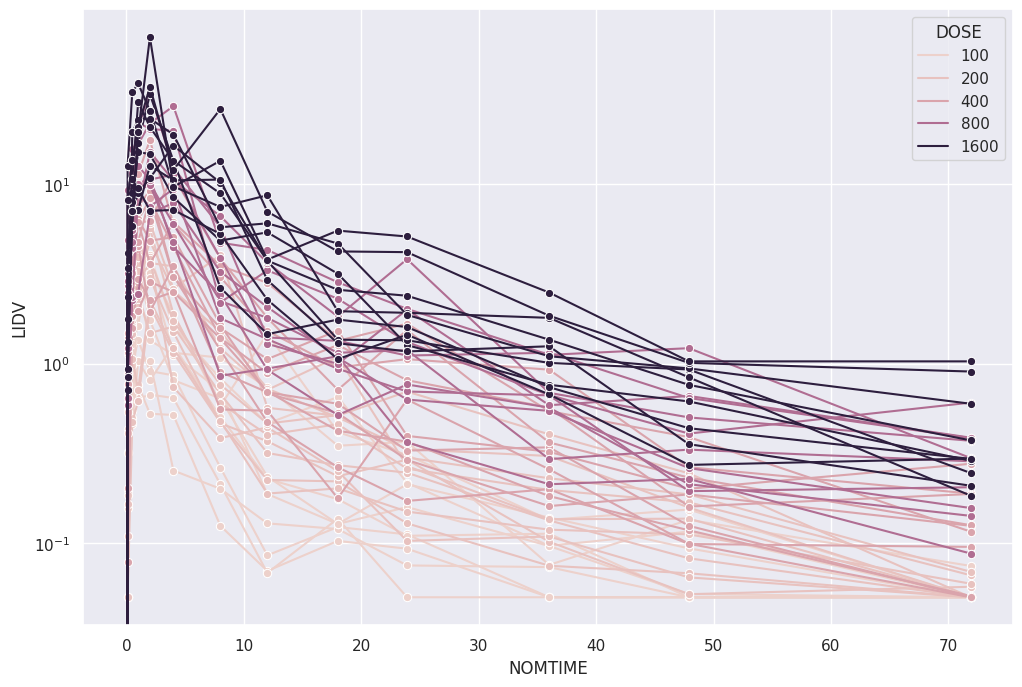

In [205]:
plt.yscale('log')
sns.lineplot(x="NOMTIME",
             y="LIDV",
             hue="DOSE",
             data=pk_data,
             units = "ID",
             estimator=None,
             marker="o")
plt.show()

## Concentration over time, faceted by Dose, dots and lines grouped by individual


In [206]:
pk_data.loc[pk_data['LIDV'] == 0, 'BLQ'] = 1
pk_data["BLQ"] = pk_data["BLQ"].fillna(0)

<Axes: xlabel='NOMTIME', ylabel='LIDV'>

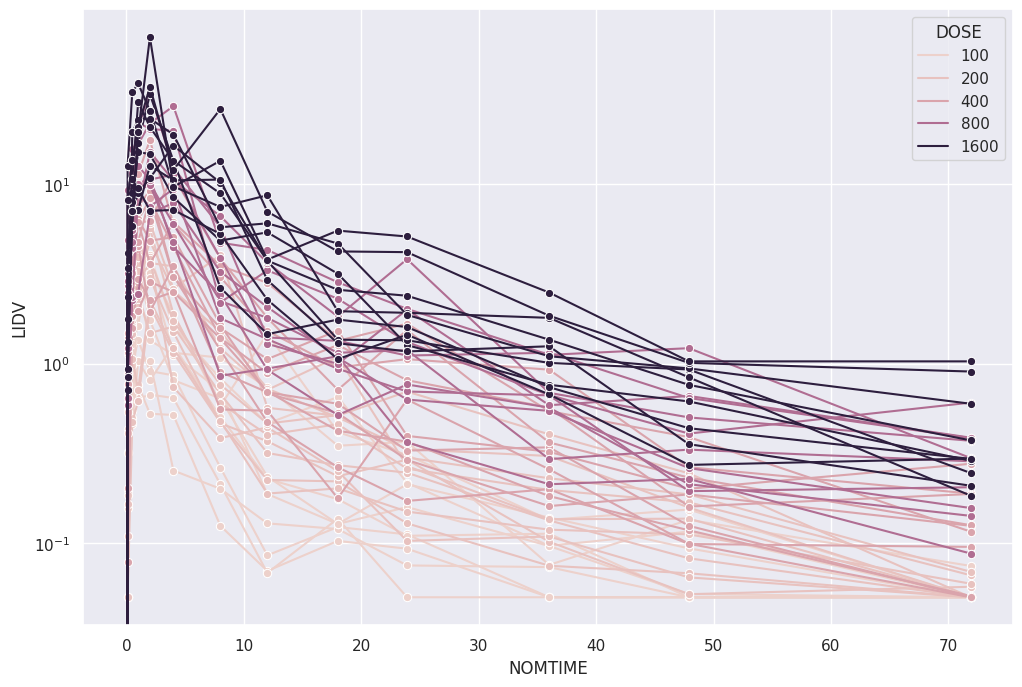

In [207]:
plt.yscale('log')
sns.lineplot(x="NOMTIME",
             y="LIDV",
             hue="DOSE",
             data=pk_data,
             units = "ID",
             estimator=None,
             marker="o")
plt.show()


<Axes: xlabel='NOMTIME', ylabel='BLQ'>

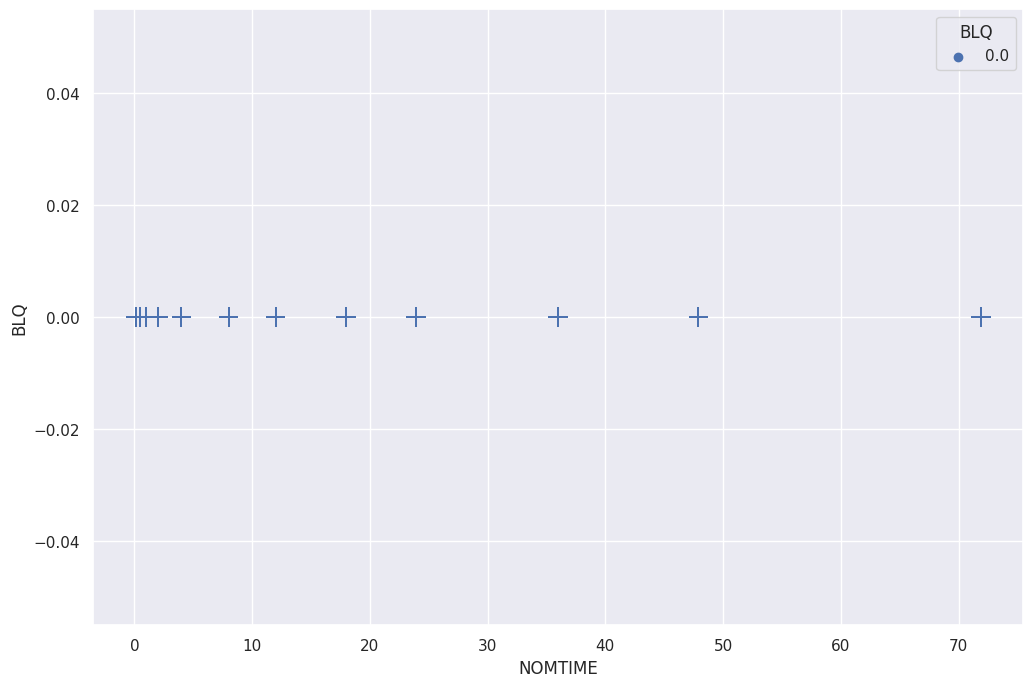

In [208]:
sns.scatterplot(data=pk_data[pk_data["BLQ"]==0],
                x='NOMTIME',
                y='BLQ',
                hue="BLQ",marker="+",
                s=200)
plt.show()

## Concentration over time, faceted by Dose, dots and lines grouped by individual

In [229]:
pk_data["LIDV_log"] = np.log(pk_data["LIDV"])


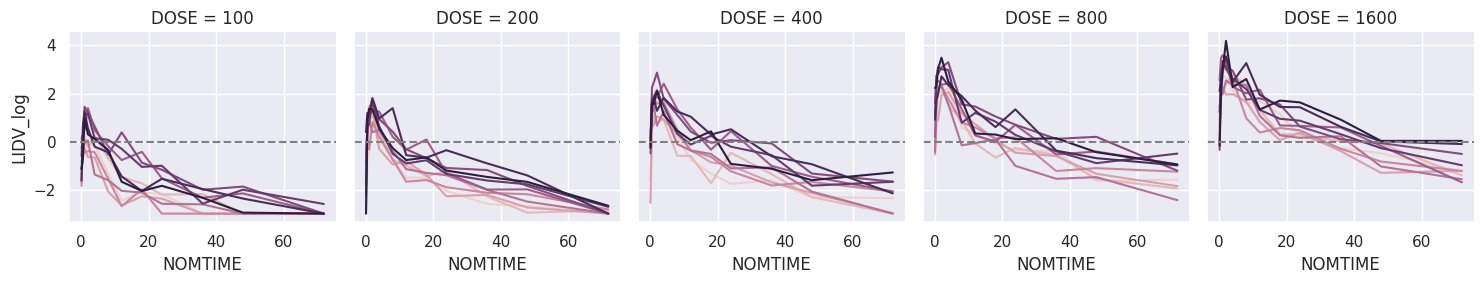

In [254]:

g = sns.FacetGrid(pk_data,
                  col="DOSE")
g.map(sns.lineplot, "NOMTIME","LIDV_log", "ID")
g.refline(y=0)
plt.show()



# Explore irregularities in profiles
Plot individual profiles in order to inspect them for any irregularities. Inspect the profiles for outlying data points that may skew results or bias conclusions. Looking at the shapes of the individual profiles now, do they support your observations made about the mean profile (e.g. number of compartments, typical Cmax, Tmax)?

Plotting individual profiles on top of gray spaghetti plots puts individual profiles into context, and may help identify outlying individuals for further inspection. Are there any individuals that appear to have very high or low Cmax compared to others within the same dose group? What about the timing of Cmax? What about the slope of the elimination phase? Does it appear that any subjects could have received an incorrect dose?

## Concentration over time, faceted by individual, individual line plots overlaid on gray spaghetti plots for that dose group

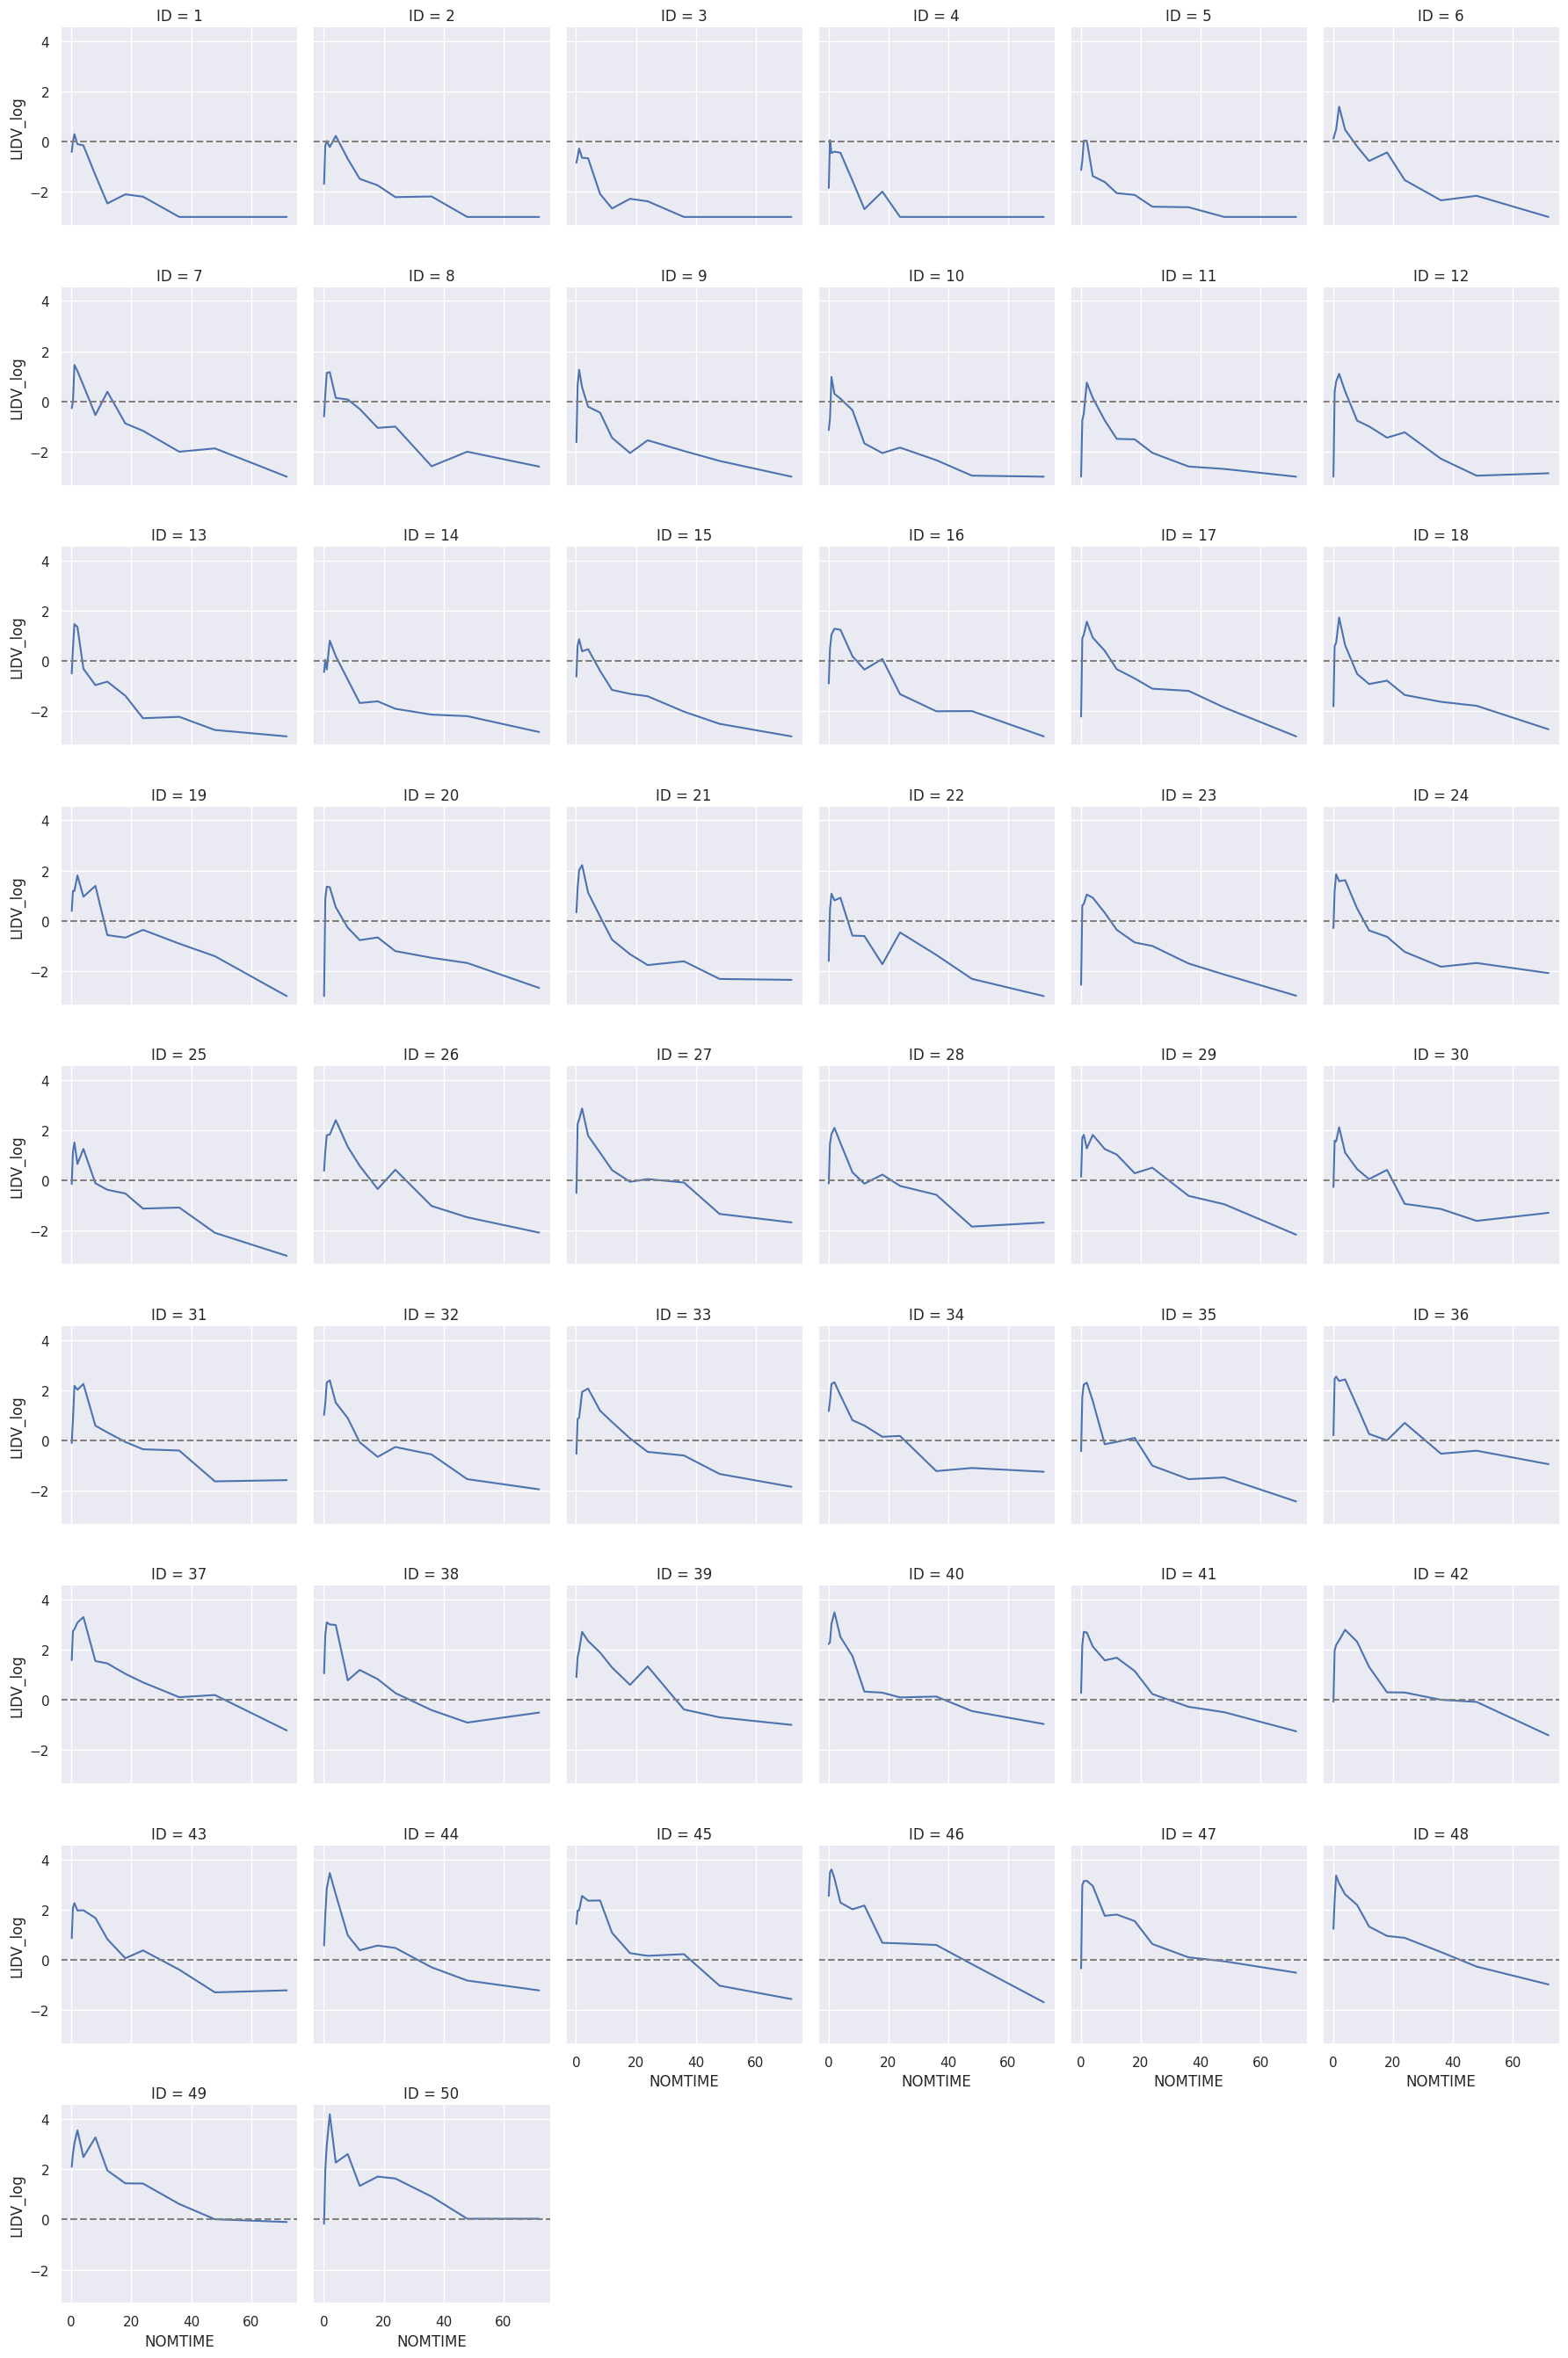

In [233]:
g = sns.FacetGrid(pk_data,
                  col="ID", col_wrap=6)
g.map(sns.lineplot, "NOMTIME","LIDV_log")
g.refline(y=0)
plt.show()

## Explore covariate effects on PK
## Concentration over time, colored by categorical covariate, mean +/- 95% CI

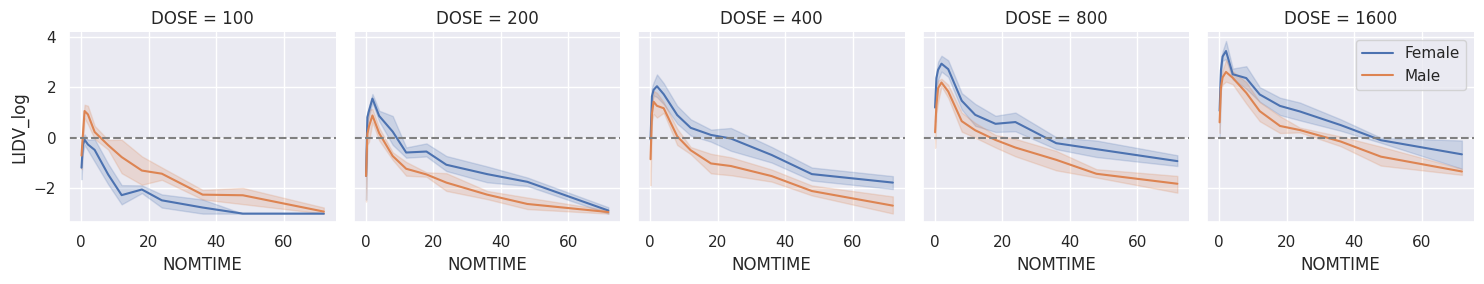

In [252]:
g = sns.FacetGrid(pk_data,
                  col="DOSE")
g.map(sns.lineplot, "NOMTIME","LIDV_log", "SEX")
g.refline(y=0)
plt.legend()
plt.show()


In [245]:
pk_data.head()

,ID,TIME,NOMTIME,TIMEUNIT,AMT,LIDV,CMT,NAME,EVENTU,CENS,EVID,WEIGHTB,SEX,DOSE,LIDV_NORM,LIDV_UNIT,TRTACT_low2high,TRTACT_high2low,BLQ,LIDV_log
0,1,-0.089,-0.1,Hours,0,0.00,2,PK Concentration,ng/mL,0,0,77.9,Male,100,NaN,ng/ml,100 mg,100 mg,1.0,-inf
102,8,0.947,1.0,Hours,0,3.11,2,PK Concentration,ng/mL,0,0,52.5,Female,100,0.0311,ng/ml,100 mg,100 mg,0.0,1.134623
101,8,0.542,0.5,Hours,0,1.29,2,PK Concentration,ng/mL,0,0,52.5,Female,100,0.0129,ng/ml,100 mg,100 mg,0.0,0.254642
100,8,0.091,0.1,Hours,0,0.55,2,PK Concentration,ng/mL,0,0,52.5,Female,100,0.0055,ng/ml,100 mg,100 mg,0.0,-0.597837
98,8,-0.061,-0.1,Hours,0,0.00,2,PK Concentration,ng/mL,0,0,52.5,Female,100,NaN,ng/ml,100 mg,100 mg,1.0,-inf


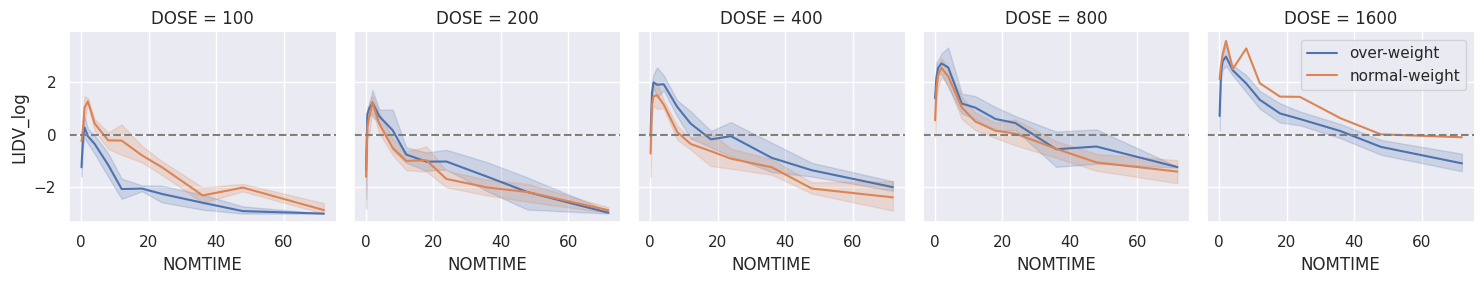

In [256]:
pk_data['OVER_WEIGHT'] = ["over-weight" if x >=70 else "normal-weight" for x in pk_data['WEIGHTB']]
g = sns.FacetGrid(pk_data,
                  col="DOSE")
g.map(sns.lineplot, "NOMTIME","LIDV_log", "OVER_WEIGHT")
g.refline(y=0)
plt.legend()
plt.show()

## Dose Normalized Concentration over time, colored by categorical covariate, mean +/- 95% CI

<Axes: xlabel='NOMTIME', ylabel='LIDV_NORM'>

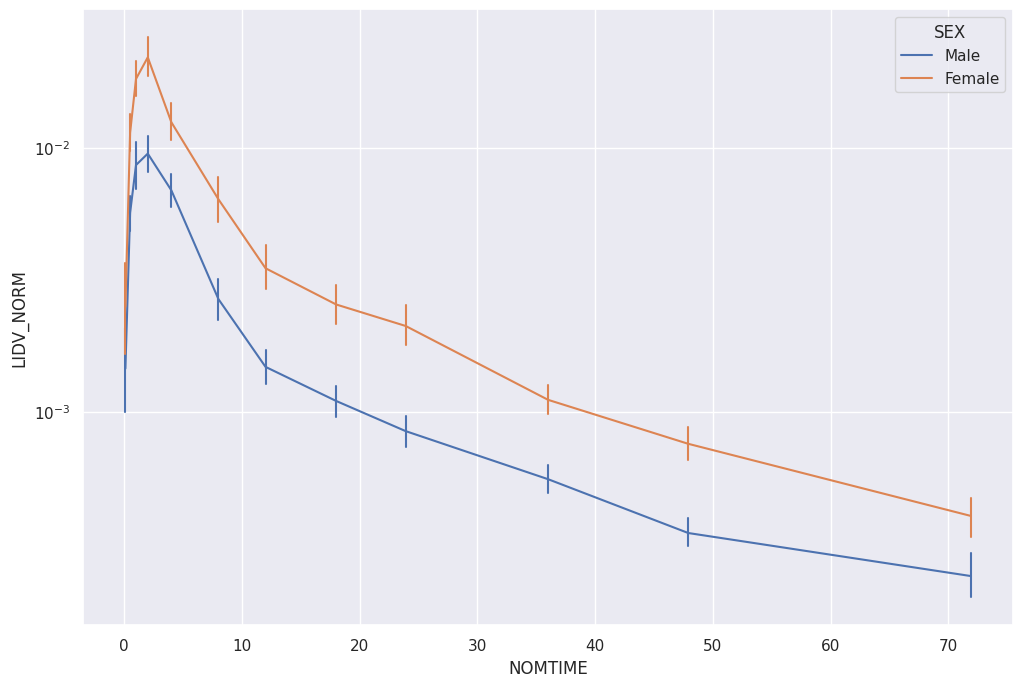

In [258]:
plt.yscale('log')
sns.lineplot(x="NOMTIME",
             y="LIDV_NORM",
             hue="SEX",
             data=pk_data,
             markers=True,
             dashes=False,
             err_style="bars",
             errorbar=("ci"))

<Axes: xlabel='NOMTIME', ylabel='LIDV_NORM'>

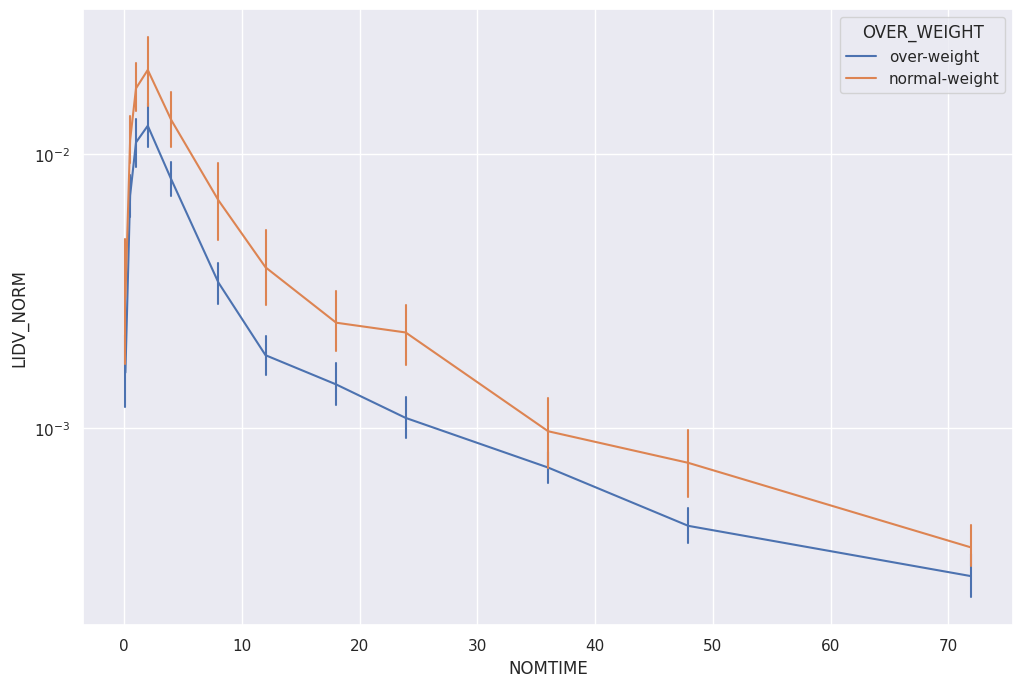

In [260]:
plt.yscale('log')
sns.lineplot(x="NOMTIME",
             y="LIDV_NORM",
             hue="OVER_WEIGHT",
             data=pk_data,
             markers=True,
             dashes=False,
             err_style="bars",
             errorbar=("ci"))

<Axes: xlabel='SEX', ylabel='VALUE_NORM'>

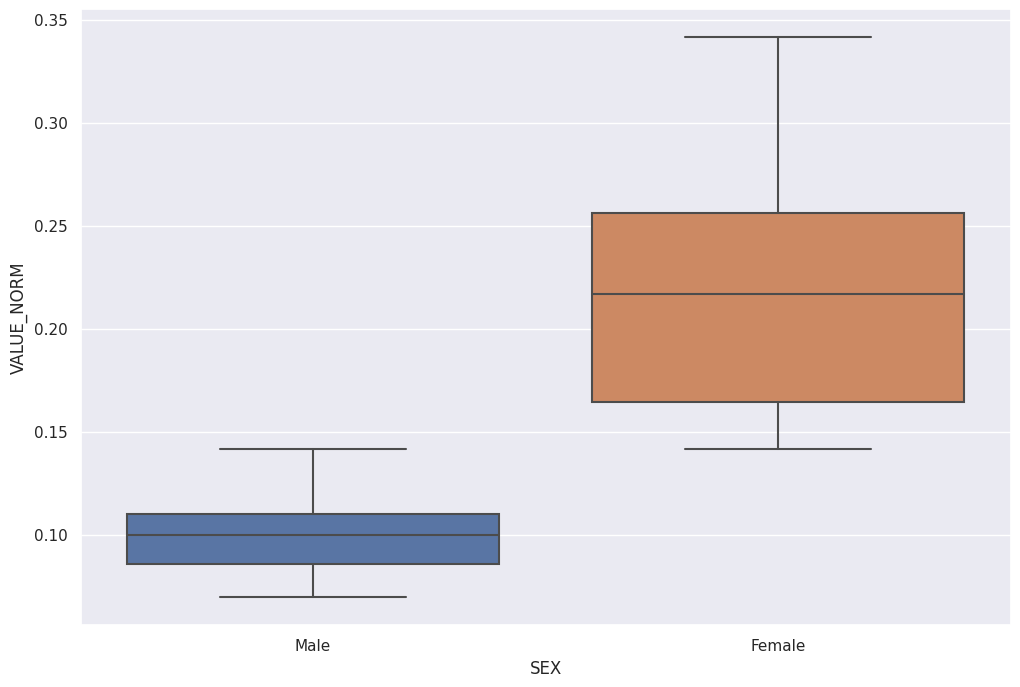

In [261]:
sns.boxplot(x="SEX", y="VALUE_NORM", data= auc)
#sns.regplot(x="DOSE", y="VALUE_NORM", data= auc, scatter=False)
plt.show()

<Axes: xlabel='SEX', ylabel='VALUE_NORM'>

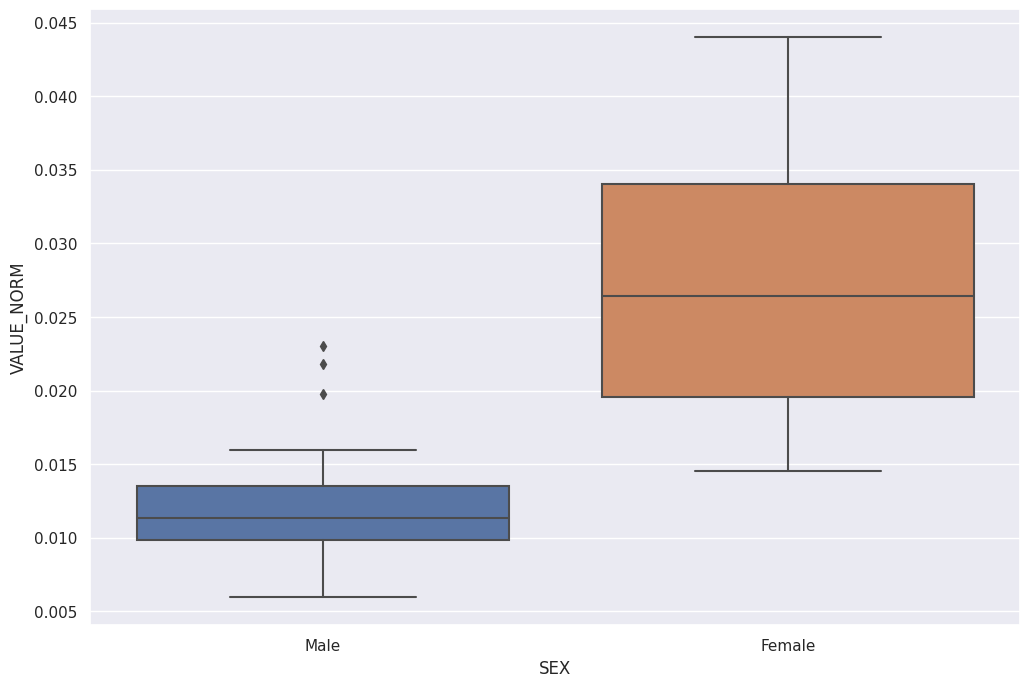

In [262]:
sns.boxplot(x="SEX", y="VALUE_NORM", data= c_max)
#sns.regplot(x="DOSE", y="VALUE_NORM", data= auc, scatter=False)
plt.show()

<Axes: xlabel='WEIGHTB', ylabel='VALUE_NORM'>

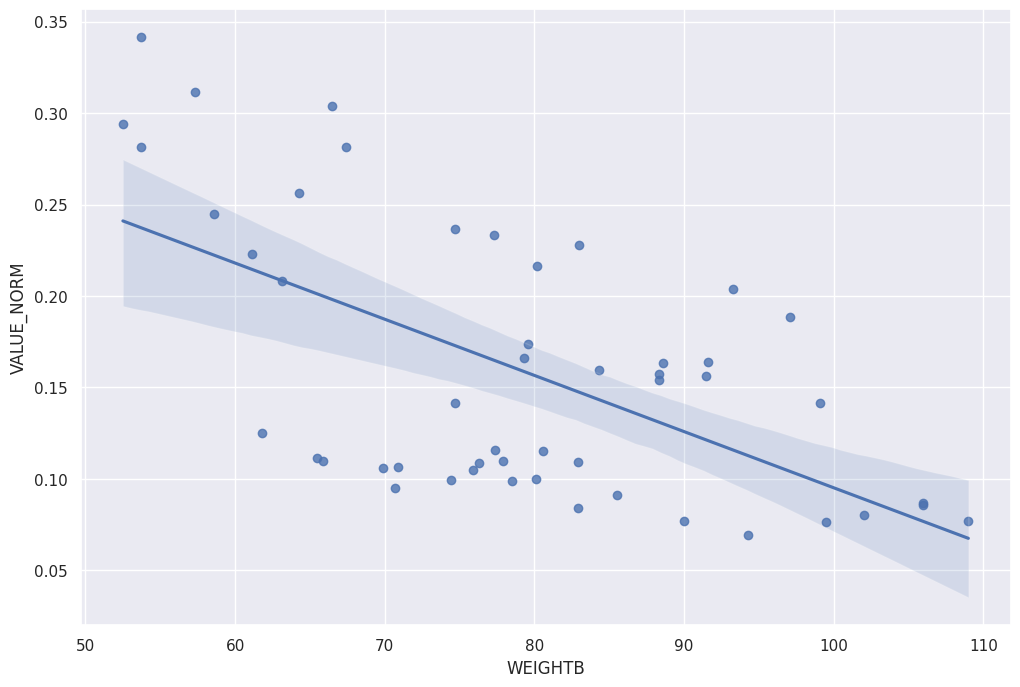

In [264]:
sns.regplot(data=auc, x="WEIGHTB", y="VALUE_NORM")

In [268]:
auc.head()

,ID,PARAM,VALUE,DOSE,SEX,WEIGHTB,VALUE_NORM
0,1,AUC_last,10.984329,100,Male,77.9,0.109843
2,2,AUC_last,14.164724,100,Male,74.7,0.141647
4,3,AUC_last,7.655013,100,Male,99.5,0.076550
6,4,AUC_last,8.668306,100,Male,106.0,0.086683
8,5,AUC_last,8.583599,100,Male,106.0,0.085836


<Axes: xlabel='WEIGHTB', ylabel='VALUE_NORM'>

<Axes: xlabel='WEIGHTB', ylabel='VALUE_NORM'>

[Text(0, 0.5, 'y'), Text(0.5, 0, 'x')]

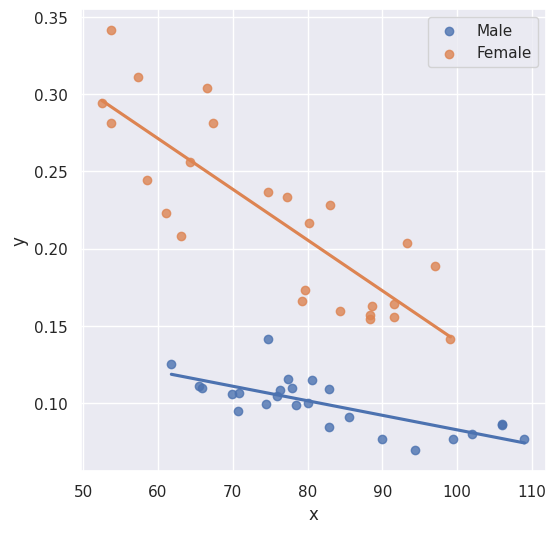

In [269]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

df1 = auc[auc["SEX"]=="Male"]
df2 = auc[auc["SEX"]!="Male"]

# add the plots for each dataframe
sns.regplot(x="WEIGHTB", y="VALUE_NORM", data=df1, fit_reg=True, ci=None, ax=ax, label='Male')
sns.regplot(x="WEIGHTB", y="VALUE_NORM", data=df2, fit_reg=True, ci=None, ax=ax, label='Female')
ax.set(ylabel='y', xlabel='x')
ax.legend()
plt.show()


<Axes: xlabel='WEIGHTB', ylabel='VALUE_NORM'>

<Axes: xlabel='WEIGHTB', ylabel='VALUE_NORM'>

[Text(0, 0.5, 'y'), Text(0.5, 0, 'x')]

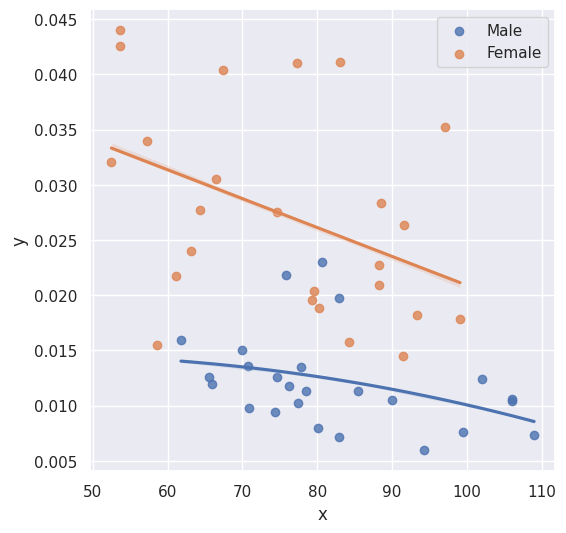

In [273]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

df1 = c_max[c_max["SEX"]=="Male"]
df2 = c_max[c_max["SEX"]!="Male"]

# add the plots for each dataframe
sns.regplot(x="WEIGHTB", y="VALUE_NORM", data=df1, fit_reg=True, ci=10, ax=ax, label='Male')
sns.regplot(x="WEIGHTB", y="VALUE_NORM", data=df2, fit_reg=True, ci=10, ax=ax, label='Female')
ax.set(ylabel='y', xlabel='x')
ax.legend()
plt.show()